# T2: Imputation and super-resolution

In [1]:
import scanpy as sc
import torch
import urllib.request
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from diffusers import DDPMScheduler
from torch_geometric.loader import NeighborLoader
from stadiffuser import pipeline
from stadiffuser.vae import SpaAE
from stadiffuser.models import SpaUNet1DModel
from stadiffuser import utils as sutils
from stadiffuser import metrics
warnings.filterwarnings("ignore")

## Load the processed data

In [3]:
# Please refer to Tutorial 1 for the `adata_processed.h5ad`.
adata_processed = sc.read_h5ad("adata_processed.h5ad")
adata_processed

AnnData object with n_obs × n_vars = 3431 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'circle-1', 'circle-2', 'circle-3', 'rectangle-1', 'rectangle-2', 'rectangle-3', 'extrapolation-1', 'extrapolation-2', 'extrapolation-3', 'random_0.05', 'random_0.1', 'random_0.2', 'random_0.3', 'random_0.4', 'random_0.5', 'random_0.6', 'random_0.8', 'random_0.9', 'strip'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ground_truth_colors', 'hvg', 'log1p', 'spatial', 'spatial_net'
    obsm: 'spatial'

## Imputation

[<Axes: title={'center': 'Slice with a hole'}, xlabel='spatial1', ylabel='spatial2'>]

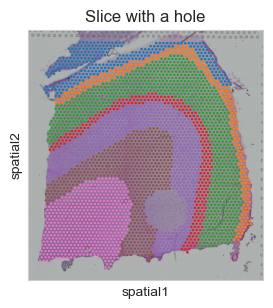

In [9]:
mask = "circle-2"
adata_mask = adata_processed.copy()
# set masked ground truth to None
adata_mask.obs["ground_truth"][~adata_mask.obs[mask]] = None
# plot the masked ground truth
fig, ax = plt.subplots(1, 1, figsize=(3.25, 3.25))
sc.pl.spatial(adata_mask, basis="spatial", color="ground_truth", ncols=1, frameon=True, wspace=0.4,
              use_raw=False, show=False, ax=ax, legend_loc='none', title="Slice with a hole")

### Train autoencoder on the masked slice

In [10]:
# prepare dataset for training
from stadiffuser.utils import mask_region
adata_mask = mask_region(adata_mask, use_mask=mask)
device = torch.device("cuda:0") # specify used device
autoencoder = SpaAE(input_dim=adata_processed.shape[1], gat_dim=[512, 32], block_out_dims=[32, 32]).to(device)
data = pipeline.prepare_dataset(adata_mask)
train_loader =  NeighborLoader(data, num_neighbors=[5, 3], batch_size=256)
autoencoder, loss = pipeline.train_autoencoder(train_loader, autoencoder, n_epochs=500,
                                               device="cuda:0")

--------------------
Remove 123 nodes and 820 edges from the original data


  0%|          | 0/500 [00:00<?, ?it/s]

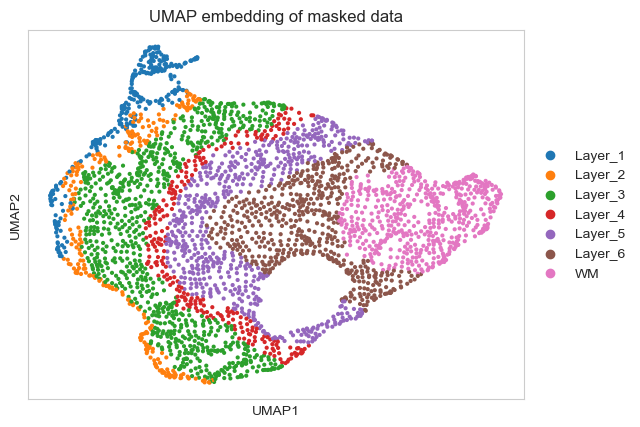

In [14]:
adata_mask_recon = pipeline.get_recon(adata_mask, autoencoder, apply_normalize=False)
# perform umap
sc.pp.neighbors(adata_mask_recon, use_rep="latent")
sc.tl.umap(adata_mask_recon, min_dist=0.5)
sc.pl.umap(adata_mask_recon, color="ground_truth", title="UMAP embedding of masked data")

### Train the denosing network on the masked slice

In [15]:
normalizer = sutils.MinMaxNormalize(adata_mask_recon.obsm["latent"], dim=0)
adata_mask_recon.obsm["normalized_latent"] = normalizer.normalize(adata_mask_recon.obsm["latent"])
# Convert the spatial coordination to the new spatial coordination
spatial_new = adata_mask_recon.obsm["spatial"].copy()
# Divide the spatial coordinates by a factor
spatial_new = sutils.quantize_coordination(spatial_new, methods=[("division", 125), ("division", 125)])
adata_mask_recon.obsm["spatial_new"] = spatial_new

Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.008, mean deviation: 0.2500386940749698, pearson correlation: 0.999855085560124
Quantize 1th dimension of spatial coordinates to 0.008, mean deviation: 0.25490689238210407, pearson correlation: 0.9998689399433924


In [16]:
data_latent = pipeline.prepare_dataset(adata_mask_recon, use_rep="normalized_latent", use_spatial="spatial_new",
                                       use_net="spatial_net")
train_loader =  NeighborLoader(data_latent, num_neighbors=[5, 3], batch_size=512)
# The denoiser model input channles = 16 (time embedding channels) + 1 (latent embedding channels)
denoiser = SpaUNet1DModel(in_channels=17, out_channels=1).to(device)
# Use DDPM scheduler to add noise gradually
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
denoiser, denoise_loss = pipeline.train_denoiser(train_loader, denoiser, noise_scheduler,
                                                 lr=1e-4, weight_decay=1e-6,
                                                 n_epochs=1000,
                                                 device=device)

  0%|          | 0/1000 [00:00<?, ?it/s]

-------------------Training Finished-------------------


### Impute the data by the denoising network

In [18]:
data = pipeline.prepare_dataset(adata_processed)
spatial_new = adata_processed.obsm["spatial"].copy()
# Divide the spatial coordinates by a factor
spatial_new = sutils.quantize_coordination(spatial_new, methods=[("division", 125), ("division", 125)])
adata_imputed = pipeline.simulate(denoiser, autoencoder, device=device,
                                  use_net="spatial_net", ref_data=adata_processed,
                                  spatial_coord=spatial_new,
                                  seed=2024, normarlizer=normalizer)

Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.008, mean deviation: 0.2500588749635675, pearson correlation: 0.999850876493874
Quantize 1th dimension of spatial coordinates to 0.008, mean deviation: 0.25002856310113675, pearson correlation: 0.9998722429659385


  0%|          | 0/1000 [00:00<?, ?it/s]

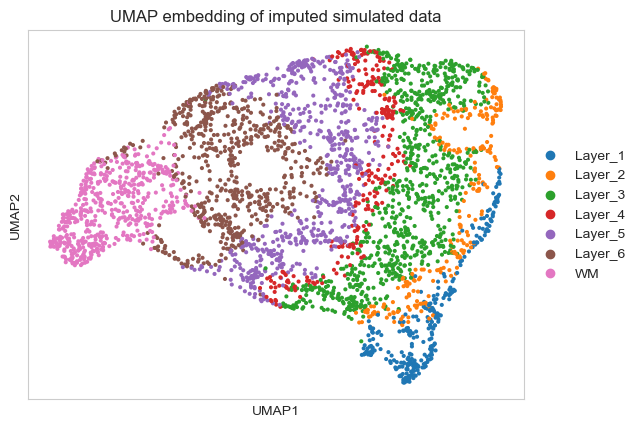

In [33]:
sc.pp.neighbors(adata_imputed, use_rep="latent")
sc.tl.umap(adata_imputed, min_dist=0.5, random_state=111)
sc.pl.umap(adata_imputed, color="ground_truth",
           title="UMAP embedding of imputed simulated data")

## Super-resolution

The super-resolution is performed by the same procedure.

In [34]:
adata_processed

AnnData object with n_obs × n_vars = 3431 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'circle-1', 'circle-2', 'circle-3', 'rectangle-1', 'rectangle-2', 'rectangle-3', 'extrapolation-1', 'extrapolation-2', 'extrapolation-3', 'random_0.05', 'random_0.1', 'random_0.2', 'random_0.3', 'random_0.4', 'random_0.5', 'random_0.6', 'random_0.8', 'random_0.9', 'strip'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ground_truth_colors', 'hvg', 'log1p', 'spatial', 'spatial_net', 'edge_list'
    obsm: 'spatial'

[<Axes: title={'center': 'Slice with a hole'}, xlabel='spatial1', ylabel='spatial2'>]

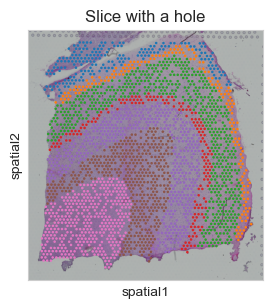

In [42]:
mask = "random_0.3"
adata_mask = adata_processed.copy()
# set masked ground truth to None
adata_mask.obs["ground_truth"][~adata_mask.obs[mask]] = None
# plot the masked ground truth
fig, ax = plt.subplots(1, 1, figsize=(3.25, 3.25))
sc.pl.spatial(adata_mask, basis="spatial", color="ground_truth", ncols=1, frameon=True, wspace=0.4,
              use_raw=False, show=False, ax=ax, legend_loc='none', title="Slice with a hole")

In [43]:
adata_mask = mask_region(adata_mask, use_mask=mask)
device = torch.device("cuda:0") # specify used device
autoencoder = SpaAE(input_dim=adata_processed.shape[1], gat_dim=[512, 32], block_out_dims=[32, 32]).to(device)
data = pipeline.prepare_dataset(adata_mask)
train_loader =  NeighborLoader(data, num_neighbors=[5, 3], batch_size=256)
autoencoder, loss = pipeline.train_autoencoder(train_loader, autoencoder, n_epochs=500,
                                               device="cuda:0")

--------------------
Remove 1026 nodes and 10130 edges from the original data


  0%|          | 0/500 [00:00<?, ?it/s]

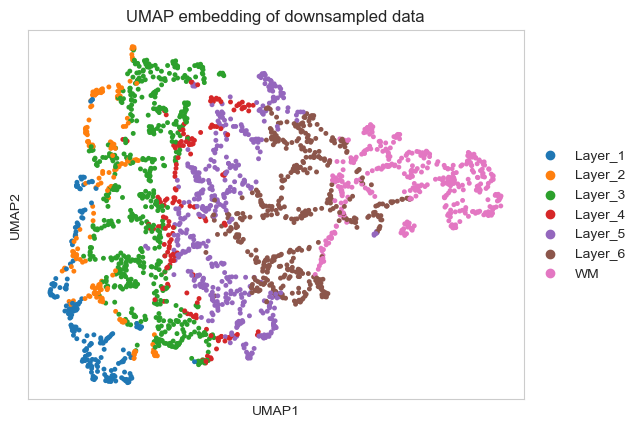

In [44]:
adata_mask_recon = pipeline.get_recon(adata_mask, autoencoder, apply_normalize=False)
# perform umap
sc.pp.neighbors(adata_mask_recon, use_rep="latent")
sc.tl.umap(adata_mask_recon, min_dist=0.5)
sc.pl.umap(adata_mask_recon, color="ground_truth", title="UMAP embedding of downsampled data")

In [45]:
normalizer = sutils.MinMaxNormalize(adata_mask_recon.obsm["latent"], dim=0)
adata_mask_recon.obsm["normalized_latent"] = normalizer.normalize(adata_mask_recon.obsm["latent"])
# Convert the spatial coordination to the new spatial coordination
spatial_new = adata_mask_recon.obsm["spatial"].copy()
# Divide the spatial coordinates by a factor
spatial_new = sutils.quantize_coordination(spatial_new, methods=[("division", 125), ("division", 125)])
adata_mask_recon.obsm["spatial_new"] = spatial_new

Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.008, mean deviation: 0.2501754677754679, pearson correlation: 0.999851591840681
Quantize 1th dimension of spatial coordinates to 0.008, mean deviation: 0.24914095634095637, pearson correlation: 0.9998721296205532


In [46]:
data_latent = pipeline.prepare_dataset(adata_mask_recon, use_rep="normalized_latent", use_spatial="spatial_new",
                                       use_net="spatial_net")
train_loader =  NeighborLoader(data_latent, num_neighbors=[5, 3], batch_size=512)
# The denoiser model input channles = 16 (time embedding channels) + 1 (latent embedding channels)
denoiser = SpaUNet1DModel(in_channels=17, out_channels=1).to(device)
# Use DDPM scheduler to add noise gradually
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
denoiser, denoise_loss = pipeline.train_denoiser(train_loader, denoiser, noise_scheduler,
                                                 lr=1e-4, weight_decay=1e-6,
                                                 n_epochs=1000,
                                                 device=device)

  0%|          | 0/1000 [00:00<?, ?it/s]

-------------------Training Finished-------------------


In [47]:
data = pipeline.prepare_dataset(adata_processed)
spatial_new = adata_processed.obsm["spatial"].copy()
# Divide the spatial coordinates by a factor
spatial_new = sutils.quantize_coordination(spatial_new, methods=[("division", 125), ("division", 125)])
adata_sr = pipeline.simulate(denoiser, autoencoder, device=device,
                                  use_net="spatial_net", ref_data=adata_processed,
                                  spatial_coord=spatial_new,
                                  seed=2024, normarlizer=normalizer)

Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.008, mean deviation: 0.2500588749635675, pearson correlation: 0.999850876493874
Quantize 1th dimension of spatial coordinates to 0.008, mean deviation: 0.25002856310113675, pearson correlation: 0.9998722429659385


  0%|          | 0/1000 [00:00<?, ?it/s]

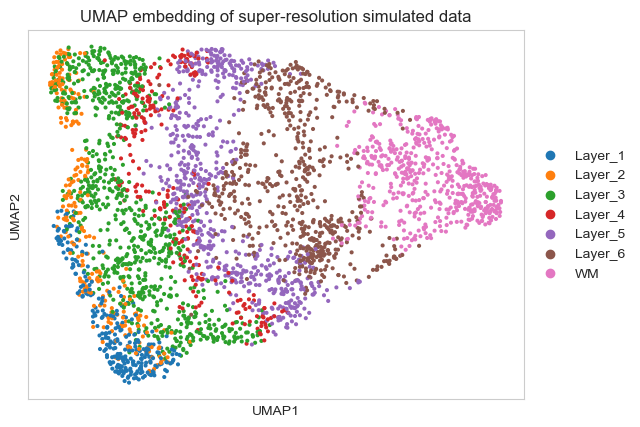

In [48]:
sc.pp.neighbors(adata_sr, use_rep="latent")
sc.tl.umap(adata_sr, min_dist=0.5, random_state=111)
sc.pl.umap(adata_sr, color="ground_truth",
           title="UMAP embedding of super-resolution simulated data")

Text(0.5, 0, 'Super resolution')

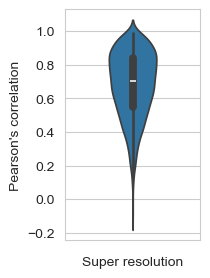

In [50]:
# load the autoencoder of full data. Refer to Tutorial 1.
autoencoder_full = torch.load("autoencoder.pth")
adata_recon = pipeline.get_recon(adata_processed, autoencoder_full, apply_normalize=False)
stadiff_corr = metrics.compute_corr(adata_sr, adata_recon, dim="gene")
# plot violin plot
fig, ax = plt.subplots(1, 1, figsize=(1.75, 3))
sns.violinplot(stadiff_corr, ax=ax, width=0.35)
ax.set_ylabel("Pearson's correlation")
ax.set_xlabel("Super resolution")